Purpose: In this project, I'm trying an Object Detection task of Computer Vision
      on the Humain Faces available on Kaggle. I'll use YOLO11

1. Data Preparing

1.1. Environment Preparation

In [ ]:
# @title a. Load Requested Libraries
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

# To diplay image
import matplotlib.image as mpimg
import numpy as np

from sklearn.model_selection import train_test_split

#from google.colab.patches import cv2_imshow    # ==> Run only if you're using Google Colab

# YOLO
#!pip install ultralytics -q
from ultralytics import YOLO

In [4]:
# @title b. Load dataset

# 1.Download latest version of the dataset
path = kagglehub.dataset_download('sbaghbidi/human-faces-object-detection')
print(f"Path to dataset files: {path}")

100%|██████████| 498M/498M [00:27<00:00, 19.0MB/s] 

Extracting files...


Path to dataset files: C:\Users\Visiteur\.cache\kagglehub\datasets\sbaghbidi\human-faces-object-detection\versions\1


In [5]:
# 2. Load dataset
data_path = path + "/faces.csv"
print(f"{data_path}")


C:\Users\Visiteur\.cache\kagglehub\datasets\sbaghbidi\human-faces-object-detection\versions\1/faces.csv


In [6]:
# Print the DataFrame
data_facing = pd.read_csv(data_path)
print(f"{data_facing}")

        image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]


1.2. Data Mining

In [8]:
# @title a. Desscriptive Statistics
data_facing.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


  A SAVOIR :
- YOLO OBB Format designates bounding boxes by their four corner points with coordinates normalized between 0 and 1. It follows this format:
    class_index x1 y1 x2 y2 x3 y3 x4 y4
    ==> TO DO: Normalize the coordinates of the points between 0 and 1
          Already done in 1.3.1
- Width = longueur du rectangle | height = largeur du rectangle

In [9]:
# Data info
data_facing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  3350 non-null   object
 1   width       3350 non-null   int64 
 2   height      3350 non-null   int64 
 3   x0          3350 non-null   int64 
 4   y0          3350 non-null   int64 
 5   x1          3350 non-null   int64 
 6   y1          3350 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 183.3+ KB


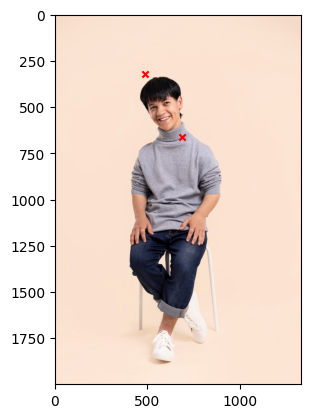

In [10]:
# Display points on image
""" Here, I'm trying to display my two (2) points that have as coordinate x0, y0, x1 and y1 on the first image."""

# Def coordonate of points
coord_pt0_img1 = data_facing.iloc[0][['x0', 'y0']]
coord_pt1_img1 = data_facing.iloc[0][['x1', 'y1']]

# --- Test - GOOD
coord_pt0_img1 = data_facing.iloc[0][['x0', 'y0']]
coord_pt1_img1 = data_facing.iloc[0][['x1', 'y1']]
coord_pt2_img1 = data_facing.iloc[0][['x0', 'y1']]
coord_pt3_img1 = data_facing.iloc[0][['x1', 'y0']]
# ---

# Def points to display
ref_pts_img1 = np.array([coord_pt0_img1, coord_pt1_img1])

# Def image 1 path
ref_path_img1 = path + "/images/" + f"{data_facing['image_name'][0]}"  # To get the path of 1st image in data_face
img_ref1 = mpimg.imread(ref_path_img1) # Iamge to display

# Display image + points
#plt.plot(145, 60, 'og', markersize=5) # og:shorthand for the green circle
plt.scatter(ref_pts_img1[:, 0], ref_pts_img1[:, 1], color='red', marker='x', s=20)
plt.imshow(img_ref1)
plt.show()

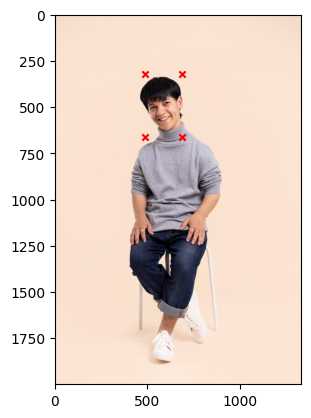

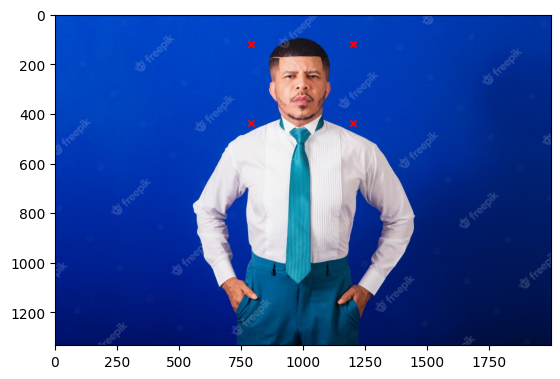

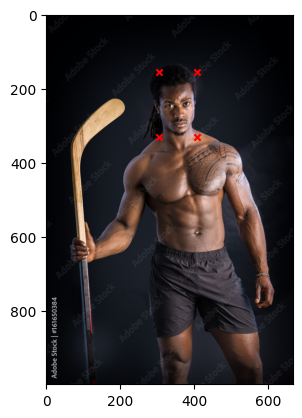

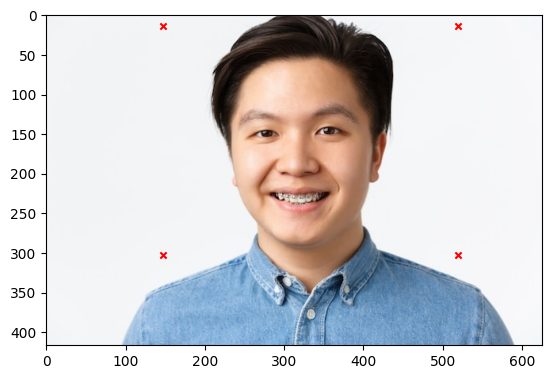

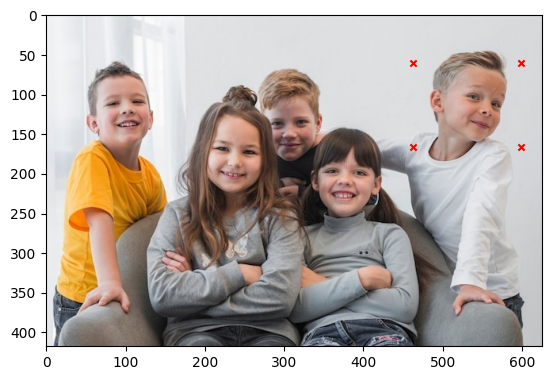

In [11]:
# Adding some cordinates
img_list = data_facing['image_name'].tolist()
img_list

for i, img in enumerate(img_list):
  coord_pt0_img = data_facing.iloc[i][['x0', 'y0']]
  coord_pt1_img = data_facing.iloc[i][['x1', 'y1']]
  coord_pt2_img = data_facing.iloc[i][['x0', 'y1']]
  coord_pt3_img = data_facing.iloc[i][['x1', 'y0']]

  # Def points to display
  ref_pts_img = np.array([coord_pt0_img, coord_pt1_img, coord_pt2_img, coord_pt3_img])

  # Def image 1 path
  ref_path_img = path + "/images/" + img  # To get the path of 1st image in data_face
  img_ref = mpimg.imread(ref_path_img) # Iamge to display

  # Display image + points
  #plt.plot(145, 60, 'og', markersize=5) # og:shorthand for the green circle
  plt.scatter(ref_pts_img[:, 0], ref_pts_img[:, 1], color='red', marker='x', s=20)
  plt.imshow(img_ref)
  plt.show()

  # Break
  if i == 4:
    break

Implementation of the YOLO model

In [12]:
# Load YOLOv11 model
model = YOLO('yolo11n.pt')

In [13]:
# Define function for Object Detection Task
def detect_objects(image_path):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error occur the image loading: {image_path}")
        return None, []

    # Detection task
    results = model(image)[0]

    detections = []
    for result in results.boxes.data.tolist():
        x0, y0, x1, y1, score, class_id = result
        detections.append([int(x0), int(y0), int(x1), int(y1), round(score, 3), results.names[int(class_id)]])

    return image, detections

# Define function to draw boxes
def draw_boxes(image, detections):
    for detection in detections:
        x0, y0, x1, y1, score, class_name = detection
        # Draw boxes
        cv2.rectangle(image, (x0, y0), (x1, y1), (0, 255, 0), 2)
        # Add label with class name and score
        label = f"{class_name} {score}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

In [16]:
# Process 20 images of the dataframe
for index, row in data_facing.sample(20).iterrows():
    image_path = os.path.join(f"{path}/images", row.iloc[0])
    print(f"Image process: {image_path}")

    # Detect objet on each image
    image, detections = detect_objects(image_path)
    if image is not None:
        image_with_boxes = draw_boxes(image, detections)

        # Show images with their boxes
        cv2.imshow("Detected Objects", image_with_boxes)  # Added window name
        
        # Add a wait key to keep the window open and allow closing
        key = cv2.waitKey(0)
        if key == ord('q') or key == 27:  # Press 'q' or 'ESC' to quit
            break

# Destroy all windows at the end
cv2.destroyAllWindows()

Image process: C:\Users\Visiteur\.cache\kagglehub\datasets\sbaghbidi\human-faces-object-detection\versions\1/images\00002608.jpg

0: 448x640 4 persons, 203.7ms
Speed: 2.9ms preprocess, 203.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Image process: C:\Users\Visiteur\.cache\kagglehub\datasets\sbaghbidi\human-faces-object-detection\versions\1/images\00003067.jpg

0: 448x640 1 person, 1 cell phone, 93.6ms
Speed: 2.5ms preprocess, 93.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Image process: C:\Users\Visiteur\.cache\kagglehub\datasets\sbaghbidi\human-faces-object-detection\versions\1/images\00001281.jpg

0: 480x640 1 person, 121.5ms
Speed: 2.6ms preprocess, 121.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
Image process: C:\Users\Visiteur\.cache\kagglehub\datasets\sbaghbidi\human-faces-object-detection\versions\1/images\00002753.jpg

0: 448x640 4 persons, 83.2ms
Speed: 2.8ms preprocess, 83.2ms inference, 0.9ms postproc